In [1]:
# Importing libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import os

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

2025-09-23 14:48:13.894650: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758638894.097157      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758638894.151182      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# ===============================
# 1. Load Data
# ===============================
import pandas as pd

# Membaca file Excel
df = pd.read_excel('/kaggle/input/lstm-train-2/LSTM Train.xlsx')

df.head()

,DATE,ALLSKY_SFC_SW_DWN,T2M,T2MDEW,WS10M,Curah,rain_accum,PRECTOTCORR,Kategori
0,2010-01-01,19.94,25.55,23.83,2.17,1.13,315.45,0.818613,Normal
1,2010-01-02,15.68,27.27,23.55,0.53,12.23,318.40,0.834272,Normal
2,2010-01-03,15.17,27.02,24.07,1.24,6.20,320.52,0.845467,Normal
3,2010-01-04,20.68,26.79,24.17,1.42,1.32,320.67,0.846257,Normal
4,2010-01-05,11.86,26.20,23.39,1.18,10.49,314.57,0.813924,Normal


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5479 entries, 0 to 5478
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   DATE               5479 non-null   datetime64[ns]
 1   ALLSKY_SFC_SW_DWN  5479 non-null   float64       
 2   T2M                5479 non-null   float64       
 3   T2MDEW             5479 non-null   float64       
 4   WS10M              5479 non-null   float64       
 5   Curah              5479 non-null   float64       
 6   rain_accum         5479 non-null   float64       
 7   PRECTOTCORR        5479 non-null   float64       
 8   Kategori           5479 non-null   object        
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 385.4+ KB


In [4]:
## features 

features_3 = ['T2M', 'T2MDEW', 'WS10M', 'PRECTOTCORR', 'ALLSKY_SFC_SW_DWN']

features = df[features_3]
features.index = df['DATE']
features.head()

,T2M,T2MDEW,WS10M,PRECTOTCORR,ALLSKY_SFC_SW_DWN
DATE,,,,,
2010-01-01,25.55,23.83,2.17,0.818613,19.94
2010-01-02,27.27,23.55,0.53,0.834272,15.68
2010-01-03,27.02,24.07,1.24,0.845467,15.17
2010-01-04,26.79,24.17,1.42,0.846257,20.68
2010-01-05,26.20,23.39,1.18,0.813924,11.86


In [5]:
## train test split for simple time series moving window average
train_split = 3836
tf.random.set_seed(13)
### standardize data
# Salin data features
# Copy dataset dari features
dataset = features.values.copy()

# Ganti inf dengan NaN
dataset = np.where(np.isinf(dataset), np.nan, dataset)

# Isi NaN dengan mean (atau median)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="mean")
dataset = imputer.fit_transform(dataset)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit transform dataset saat training
dataset = scaler.fit_transform(dataset)

In [6]:
# =========================
# Lihat hasil normalisasi
# =========================
# Konversi kembali ke DataFrame biar rapi
dataset_scaled = pd.DataFrame(dataset, columns=features.columns)

print("\n🔍 5 data teratas setelah normalisasi:")
print(dataset_scaled.head())

print("\n📈 Statistik deskriptif setelah normalisasi:")
print(dataset_scaled.describe().T[["mean", "std", "min", "max"]])


🔍 5 data teratas setelah normalisasi:
        T2M    T2MDEW     WS10M  PRECTOTCORR  ALLSKY_SFC_SW_DWN
0 -1.062324 -0.080051  0.126390     0.800129           0.794051
1  1.135055 -0.431844 -2.378316     0.815722          -0.588811
2  0.815668  0.221486 -1.293962     0.826870          -0.754365
3  0.521833  0.347126 -1.019055     0.827657           1.034266
4 -0.231919 -0.632868 -1.385597     0.795459          -1.828842

📈 Statistik deskriptif setelah normalisasi:
                           mean       std       min       max
T2M                9.721169e-14  1.000091 -4.575574  4.648305
T2MDEW             4.126050e-14  1.000091 -6.236428  2.922754
WS10M              6.536111e-16  1.000091 -2.378316  3.165637
PRECTOTCORR        1.089352e-16  1.000091 -5.423180  3.103666
ALLSKY_SFC_SW_DWN  1.623653e-15  1.000091 -4.815304  2.913789


In [7]:
### create mutlivariate data

def mutlivariate_data(dataset , target , start_idx , end_idx , history_size , target_size,
                      step ,  single_step = False):
  data = []
  labels = []
  start_idx = start_idx + history_size
  if end_idx is None:
    end_idx = len(dataset)- target_size
  for i in range(start_idx , end_idx ):
    idxs = range(i-history_size, i, step) ### using step
    data.append(dataset[idxs])
    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data) , np.array(labels)

In [8]:
### generate multivariate data

history =30
future_target = 1
STEP = 1

x_train_ss , y_train_ss = mutlivariate_data(dataset , dataset[:, 3], 0, train_split, history,
                                            future_target, STEP , single_step = True)

x_val_ss , y_val_ss = mutlivariate_data(dataset , dataset[:,3] , train_split , None , history ,
                                        future_target, STEP, single_step = True)

print(x_train_ss.shape , y_train_ss.shape)

(3806, 30, 5) (3806,)


In [9]:
## tensorflow dataset
## prepare tensorflow dataset
batch_size = 128
buffer_size = 10000
train_ss = tf.data.Dataset.from_tensor_slices((x_train_ss, y_train_ss))
train_ss = train_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()

# Validation dataset → hanya batch, jangan shuffle
val_ss = tf.data.Dataset.from_tensor_slices((x_val_ss, y_val_ss))
val_ss = val_ss.cache().batch(batch_size).repeat()

print(train_ss)
print(val_ss)

I0000 00:00:1758638911.423792      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


<_RepeatDataset element_spec=(TensorSpec(shape=(None, 30, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
<_RepeatDataset element_spec=(TensorSpec(shape=(None, 30, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


In [10]:
### Modelling using LSTM
EPOCHS =100
steps = 200
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Attention, GlobalAveragePooling1D

single_step_model = tf.keras.Sequential()

# Dense sebelum LSTM (100 unit)
single_step_model.add(tf.keras.layers.Dense(100, activation='tanh', input_shape=x_train_ss.shape[-2:]))

# LSTM layer (100 unit)
single_step_model.add(tf.keras.layers.LSTM(100, return_sequences=False))

single_step_model.add(tf.keras.layers.Dense(100, activation='tanh'))

# Dropout
single_step_model.add(tf.keras.layers.Dropout(0.5))

# Output layer (regression → 1 neuron)
single_step_model.add(tf.keras.layers.Dense(1))

# Tampilkan ringkasan arsitektur model baru Anda
single_step_model.summary()


single_step_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001), loss='mae')
single_step_model_history = single_step_model.fit(train_ss, epochs = EPOCHS , 
                                                  steps_per_epoch =steps, validation_data = val_ss,
                                                  validation_steps = 50)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 30, 100)        │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,201 (356.25 KB)

 Trainable params: 91,201 (356.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


I0000 00:00:1758638917.740210      56 cuda_dnn.cc:529] Loaded cuDNN version 90300


200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.7411 - val_loss: 0.4150
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3819 - val_loss: 0.2791
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2936 - val_loss: 0.2461
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2660 - val_loss: 0.2311
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2485 - val_loss: 0.2184
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2343 - val_loss: 0.2065
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2223 - val_loss: 0.1992
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2125 - val_loss: 0.1947
Epoch 9/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2089 - val_loss: 0.1899
Epoch 10/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2015 - val_loss: 0.1875
Epoch 11/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1971 - val_loss: 0.1847
Epoch 12/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

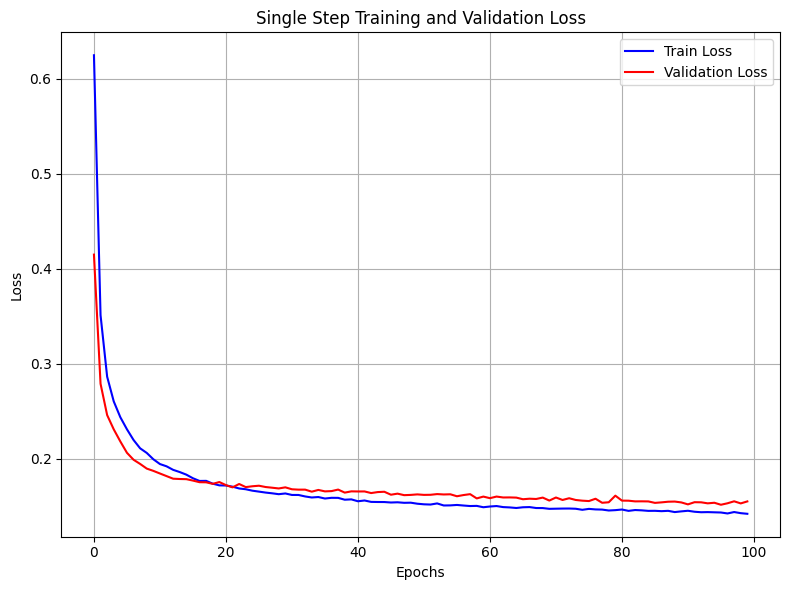

In [11]:
def plot_loss(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))
    plt.figure(figsize=(8,6))
    plt.plot(epochs, loss, 'b', label='Train Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Simpan grafik
    plt.savefig("train_val_loss.tiff", format="tiff", dpi=300)  # TIFF
    plt.savefig("train_val_loss.eps", format="eps", dpi=300)    # EPS

    plt.show()

# Panggil fungsi
plot_loss(single_step_model_history, 'Single Step Training and Validation Loss')

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


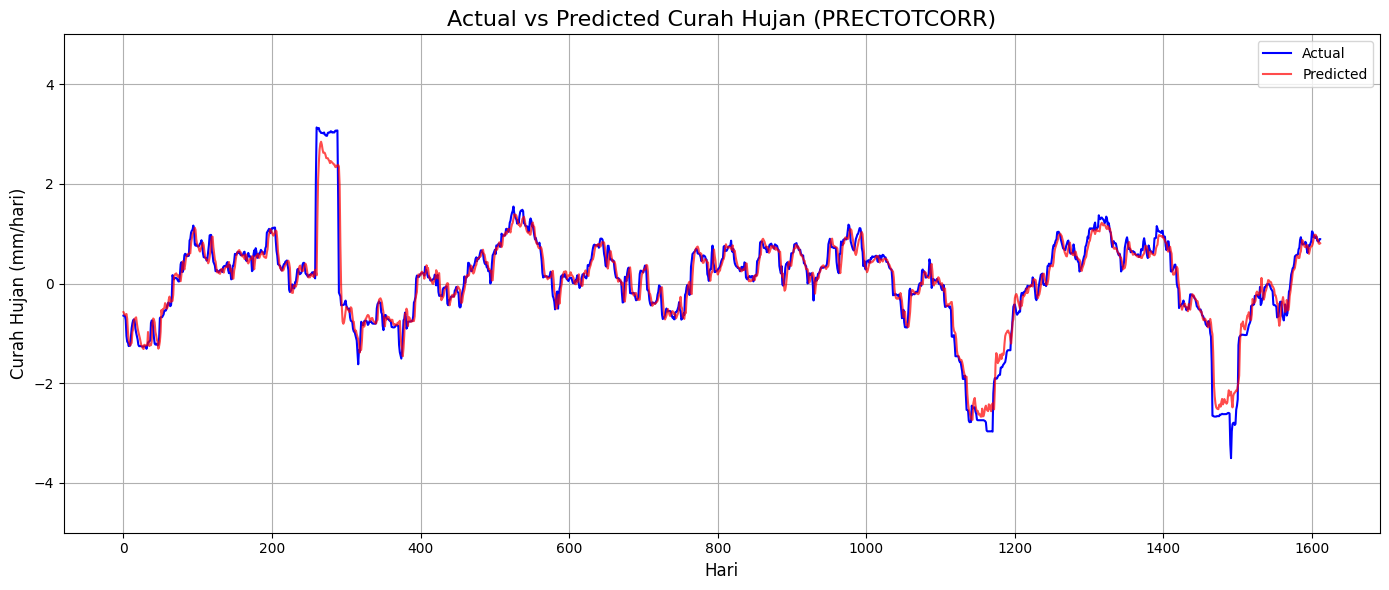

In [12]:
# Index target sesuai urutan training
TARGET_IDX = 3

# Prediksi (scaled)
y_pred_scaled = single_step_model.predict(x_val_ss).flatten()
y_true_scaled = y_val_ss.flatten()

# Denormalisasi pakai scaler sklearn
# (gunakan inverse_transform, bukan manual rumus)
def inverse_standard(scaled_data, target_idx, scaler):
    """
    Denormalisasi satu kolom target dari hasil StandardScaler
    """
    dummy = np.zeros((len(scaled_data), scaler.n_features_in_))
    dummy[:, target_idx] = scaled_data
    return scaler.inverse_transform(dummy)[:, target_idx]

y_pred_original = inverse_standard(y_pred_scaled, TARGET_IDX, scaler)
y_true_original = inverse_standard(y_true_scaled, TARGET_IDX, scaler)


# Plot hasil
plt.figure(figsize=(14, 6))
plt.plot(y_true_original, label="Actual", color='blue')
plt.plot(y_pred_original, label="Predicted", color='red', alpha=0.7)
plt.title("Actual vs Predicted Curah Hujan (PRECTOTCORR)", fontsize=16)
plt.xlabel("Hari", fontsize=12)
plt.ylabel("Curah Hujan (mm/hari)", fontsize=12)
plt.legend()
plt.grid(True)

# Batasi sumbu Y 0–80
plt.ylim(-5, 5)

plt.tight_layout()

plt.show()

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Inverse transform supaya balik ke skala asli
# Dataset standar = (x - mean) / std → balik ke asli


# Hitung metrik evaluasi
mae = mean_absolute_error(y_true_original, y_pred_original)
rmse = mean_squared_error(y_true_original, y_pred_original, squared=False)

print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")

MAE  : 0.1573
RMSE : 0.2507


In [14]:
import tensorflow as tf
import joblib
import shutil

# === 1. Simpan model setelah training ===
model_path = "/kaggle/working/saved_lstm_model.keras"
single_step_model.save(model_path)
print(f"✅ Model saved to {model_path}")

# === 2. Simpan scaler ===
scaler_path = "/kaggle/working/scaler.pkl"
joblib.dump(scaler, scaler_path)
print(f"✅ Scaler saved to {scaler_path}")


print("📦 File model_bundle.zip siap diunduh dari tab Output Kaggle")


✅ Model saved to /kaggle/working/saved_lstm_model.keras
✅ Scaler saved to /kaggle/working/scaler.pkl
📦 File model_bundle.zip siap diunduh dari tab Output Kaggle


In [15]:
import pandas as pd
import numpy as np
# =========================
# Konfigurasi Utama
# =========================
FILE_DATA    = "/kaggle/input/muara-kuang-fc-spi/Muara Kuang forecast var.xlsx"   # ganti path dataset
OUT_PRED_CSV = "prediksi_tanjungbatu.csv"

DATE_COL   = "DATE"

# Urutan kolom HARUS sama dengan saat training!
COLS_4 = ["T2M", "T2MDEW", "WS10M", "PRECTOTCORR", "ALLSKY_SFC_SW_DWN"]

COL_TARGET = "PRECTOTCORR"
WINDOW = 30
MODEL_OUTPUT_IS_SCALED = True

In [16]:
# =========================
# Load data
# =========================
print("Memuat data:", FILE_DATA)
df = pd.read_excel(FILE_DATA)

# Pastikan kolom DATE jadi datetime
df[DATE_COL] = pd.to_datetime(df[DATE_COL], dayfirst=True)

# Pastikan target ada walau kosong
if COL_TARGET not in df.columns:
    df[COL_TARGET] = np.nan

# Ambil warm-up (30 baris pertama dengan target)
df_known = df[df[COL_TARGET].notna()].copy()
if len(df_known) < WINDOW:
    raise ValueError(f"Data target diketahui kurang dari {WINDOW} baris, hanya {len(df_known)}.")

# Pilih sesuai urutan training
warmup = df_known.iloc[:WINDOW][COLS_4].copy()

# Ambil horizon setelah warmup (baris 31 dst)
start_horizon_idx = df.index.get_loc(warmup.index[-1]) + 1
horizon_df = df.iloc[start_horizon_idx:].copy()
if horizon_df.empty:
    raise ValueError("Tidak ada horizon (setelah warmup).")

Memuat data: /kaggle/input/muara-kuang-fc-spi/Muara Kuang forecast var.xlsx


In [17]:
# =========================
# Gunakan scaler hasil training (sudah ada di RAM)
# =========================
warmup_values = warmup[COLS_4].values
warmup_scaled = scaler.transform(warmup_values)  # scaler hasil training

# Buffer untuk sliding window
buffer_scaled = list(warmup_scaled)

In [18]:
# =========================
# Loop prediksi
# =========================
preds_orig = []

for i in range(len(horizon_df)):
    # Window terakhir (30 hari terakhir)
    window_arr = np.array(buffer_scaled[-WINDOW:])
    X = window_arr[np.newaxis, :, :]

    # Prediksi (masih skala StandardScaler)
    y_pred_scaled = float(single_step_model.predict(X, verbose=0).ravel()[0])

    # Denormalisasi target
    y_pred_orig = inverse_standard([y_pred_scaled], TARGET_IDX, scaler)[0]
    preds_orig.append(y_pred_orig)

    # Susun row baru (urutan sesuai TRAIN_COLS)
    exog_orig_row = horizon_df.iloc[i][[c for c in COLS_4 if c != COL_TARGET]].values.astype(float)
    new_row_orig = np.insert(exog_orig_row, TARGET_IDX, y_pred_orig)

    # Transform row baru dengan scaler yang sama
    new_row_scaled = scaler.transform(new_row_orig.reshape(1, -1))[0]
    buffer_scaled.append(new_row_scaled)

In [19]:
# =========================
# Fungsi klasifikasi SPI
# =========================
def classify_spi(value):
    if value >= 2: return "Sangat Basah"
    elif 1.5 <= value < 2: return "Basah Ekstrem"
    elif 1 <= value < 1.5: return "Basah Sedang"
    elif -1 < value < 1: return "Normal"
    elif -1.5 < value <= -1: return "Kering Sedang"
    elif -2 < value <= -1.5: return "Kering Parah"
    elif value <= -2: return "Kering Sangat Parah"
    else: return "Tidak Terkategori"

# =========================
# Output hasil
# =========================
OUT_PRED_CSV = "/kaggle/working/prediksi.csv"  # simpan di working directory

result = horizon_df[[DATE_COL] + [c for c in COLS_4 if c != COL_TARGET]].copy()
result[COL_TARGET + "_PRED"] = preds_orig

# Tambahkan klasifikasi SPI
result["KATEGORI_SPI"] = result[COL_TARGET + "_PRED"].apply(classify_spi)

# Simpan ke CSV
result.to_csv(OUT_PRED_CSV, index=False)

print("✅ Selesai. Hasil disimpan di:", OUT_PRED_CSV)
print(result.head())
print("Total baris diprediksi:", len(result))


✅ Selesai. Hasil disimpan di: /kaggle/working/prediksi.csv
         DATE    T2M  T2MDEW  WS10M  ALLSKY_SFC_SW_DWN  PRECTOTCORR_PRED  \
30 2025-01-01  25.84   23.77   2.79              13.89          0.823499   
31 2025-01-02  26.27   23.75   2.74              18.99          0.782894   
32 2025-01-03  26.06   23.93   2.44              17.27          0.742993   
33 2025-01-04  26.53   24.05   2.69              18.02          0.732310   
34 2025-01-05  26.03   24.13   2.23              15.57          0.707098   

   KATEGORI_SPI  
30       Normal  
31       Normal  
32       Normal  
33       Normal  
34       Normal  
Total baris diprediksi: 730


In [20]:
# =========================
# Hitung jumlah data per kelas SPI
# =========================
class_counts = result["KATEGORI_SPI"].value_counts().reset_index()
class_counts.columns = ["KATEGORI_SPI", "JUMLAH"]

print("\n📊 Jumlah data per kelas SPI:")
print(class_counts)



📊 Jumlah data per kelas SPI:
    KATEGORI_SPI  JUMLAH
0         Normal     713
1  Kering Sedang      13
2   Kering Parah       4


<Figure size 1000x600 with 0 Axes>

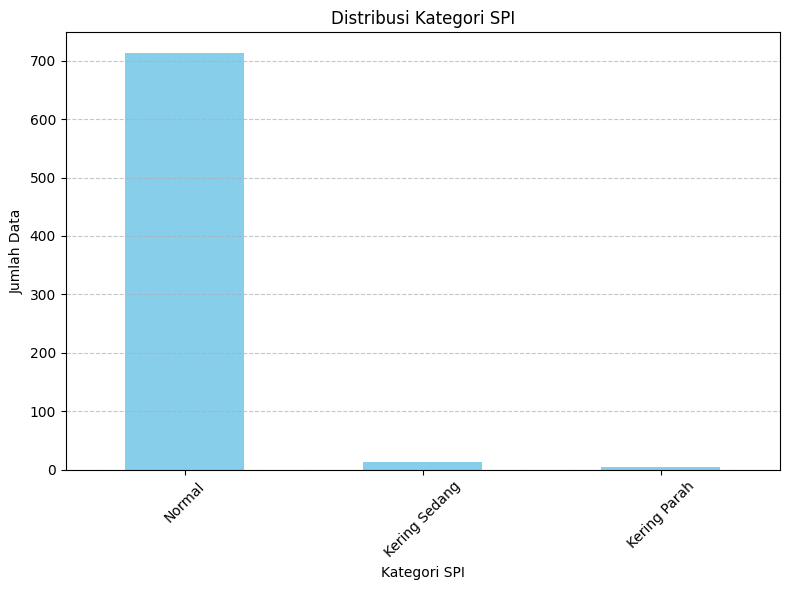

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
class_counts.set_index("KATEGORI_SPI").plot(kind="bar", legend=False, color="skyblue")

plt.title("Distribusi Kategori SPI")
plt.xlabel("Kategori SPI")
plt.ylabel("Jumlah Data")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()